### Generating a contamination model

This notebook covers generating a segmentation map, detection catalogue, and contamination model.

As before, we setup the directory structure and environment variables.

In [1]:
import os
from pathlib import Path

# This is currently a necessity; newer pipeline reductions do not work well with grizli
os.environ["CRDS_CONTEXT"] = "jwst_1173.pmap"

root_dir = Path(os.getenv("ROOT_DIR"))

In [2]:
import shutil, logging
from astropy.io import fits
import grizli
from grizli import utils, prep, jwst_utils, multifit
from grizli.pipeline import auto_script
import numpy as np

print("Grizli version: ", grizli.__version__)

# Quiet JWST log warnings
jwst_utils.QUIET_LEVEL = logging.WARNING
jwst_utils.set_quiet_logging(jwst_utils.QUIET_LEVEL)

root_name = "glass-a2744"

# Set up the grizli directory structure
grizli_home_dir = root_dir / "2024_08_16_A2744_v4" / "grizli_home_refine_contam_old_seg"
(grizli_home_dir / "Prep").mkdir(exist_ok=True, parents=True)
(grizli_home_dir / "Extractions").mkdir(exist_ok=True, parents=True)

os.chdir(grizli_home_dir / "Prep")

Grizli version:  1.12.8


Let's start by generating a catalogue with the default parameters, and seeing how that looks.

In [3]:
multiband_catalog_args = auto_script.get_yml_parameters()["multiband_catalog_args"]

phot_cat = auto_script.multiband_catalog(field_root=root_name, **multiband_catalog_args)

# (2025-05-09 14:58:46.503)

auto_script.multiband_catalog(**{'field_root': 'glass-a2744', 'threshold': 1.0, 'detection_background': True, 'photometry_background': True, 'get_all_filters': False, 'filters': None, 'det_err_scale': -inf, 'phot_err_scale': -inf, 'rescale_weight': False, 'run_detection': True, 'detection_filter': 'ir', 'detection_root': None, 'output_root': None, 'use_psf_filter': True, 'detection_params': {'minarea': 9, 'filter_kernel': array([[0.0049, 0.0213, 0.0513, 0.0687, 0.0513, 0.0213, 0.0049],
       [0.0213, 0.0921, 0.2211, 0.296 , 0.2211, 0.0921, 0.0213],
       [0.0513, 0.2211, 0.5307, 0.7105, 0.5307, 0.2211, 0.0513],
       [0.0687, 0.296 , 0.7105, 0.9511, 0.7105, 0.296 , 0.0687],
       [0.0513, 0.2211, 0.5307, 0.7105, 0.5307, 0.2211, 0.0513],
       [0.0213, 0.0921, 0.2211, 0.296 , 0.2211, 0.0921, 0.0213],
       [0.0049, 0.0213, 0.0513, 0.0687, 0.0513, 0.0213, 0.0049]]), 'filter_type': 'conv', 'clean': True, 'clean_param': 1, 'deblend_nthresh': 32, 'deblend_

We show a quick plot of the areas not included in the segmentation map.

In [4]:
# from astropy.table import Table, join
# from astropy.coordinates import SkyCoord, match_coordinates_sky
# import matplotlib.pyplot as plt
# import astropy.visualization as astrovis

# plot = True

# prev_seg_map = fits.getdata(f"{root_name}-ir_seg.fits").astype(int)

# detect_img = fits.getdata(f"{root_name}-ir_drc_sci.fits")

# if plot:

#     fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
#     plot_kwargs = {
#         "norm": astrovis.ImageNormalize(
#             detect_img,
#             interval=astrovis.ManualInterval(0, 5),
#             stretch=astrovis.LogStretch(),
#         ),
#         "origin": "lower",
#         "cmap": "plasma",
#     }
#     axs[0].imshow(
#         detect_img,
#         **plot_kwargs,
#     )
#     axs[1].imshow(
#         detect_img * (1 - (prev_seg_map > 0)),
#         **plot_kwargs,
#     )

A significant fraction of the light in the cluster is not included in the segmentation map. This missing light will not be accounted for in the contamination model, and will cause problems for any overlapping objects in the dispersed image. 

This can be solved by making two changes:

* Lowering the detection threshold.
* Not subtracting a background from the detection image.

The latter is particularly important for cluster observations.

Here, we use `photutils` to generate a new segmentation map. The primary purpose here is to include as much of the light as possible; the exact source deblending is a matter of preference.

In [5]:
# from astropy.convolution import convolve, Gaussian2DKernel
# from photutils.segmentation import SegmentationImage, SourceCatalog, SourceFinder

# detect_img = fits.getdata(f"{root_name}-ir_drc_sci.fits")
# detect_wht = fits.getdata(f"{root_name}-ir_drc_wht.fits")

# err = np.sqrt(1 / detect_wht)

# pixel_stddev = 3

# # Smooth the detection image
# conv_detect = convolve(detect_img, Gaussian2DKernel(pixel_stddev))

# # Mask any bad pixels
# mask = (~np.isfinite(detect_img)) | (~np.isfinite(err)) | (~np.isfinite(detect_img))

# # The minimum contrast ratio between detected peaks when deblending
# contrast = 1e-5
# # The number of levels to use when deblending
# nlevels = 32
# # The minimum number of connected pixels for a source to be detected
# npixels = 9
# # The number of CPU processes to use for deblending
# nproc = 16
# # The connectivity for each pixel: 8 includes diagonal connections
# connectivity = 8

# finder = SourceFinder(
#     npixels=npixels,
#     nlevels=nlevels,
#     contrast=contrast,
#     nproc=16,
#     connectivity=connectivity,
# )
# segment_map = finder(
#     conv_detect,
#     threshold=1.0 * err, # Use a low detection threshold
# )

# new_seg_hdul = fits.HDUList(
#     hdus=[
#         fits.PrimaryHDU(
#             data=segment_map.copy(),
#             header=fits.getheader(f"{root_name}-ir_drc_sci.fits"),
#         ),
#     ]
# )
# new_seg_hdul.writeto(
#     f"photutils_seg_map_{nlevels}_{contrast:.0E}_{connectivity}.fits", overwrite=True
# )

<div class="alert alert-info">

**Note:**

At this point, further source deblending is a matter of personal preference, and will heavily depend on the individual science case. For the GLASS A2744 field, I combined the `photutils` segmentation map with a previous `sep`-derived map manually, as `sep` (or `sep-pjw`) produced more irregular shapes, better matched to the shape of the PSF from foreground stars. For most cases, the `photutils` map is likely to be sufficient.

</div>

Now we regenerate both the detection catalogue, and multiband photometric catalogue, following the `grizli` format for both.

In [6]:
# from glass_niriss.pipeline import regen_catalogue

# # Or whatever name you came up with after the previous step
# # prev_seg_name = f"forced_extract_seg.fits"
# prev_seg_name = "glass-a2744-ir_seg_mod_3_ordered2.fits"

# segment_map = fits.getdata(prev_seg_name)

# use_regen_seg = np.asarray(segment_map).astype(np.int32)
# new_cat = regen_catalogue(
#     use_regen_seg,
#     root=f"{root_name}-ir",
# )

In [7]:
# prev_cat_name = f"{root_name}-ir.cat.fits"

# multiband_catalog_args = auto_script.get_yml_parameters()["multiband_catalog_args"]
# multiband_catalog_args["run_detection"] = False
# multiband_catalog_args["filters"] = ["f115wn-clear","f150wn-clear","f200wn-clear"]

# if not (Path.cwd() / f"{root_name}_phot.fits").is_file():
#     phot_cat = auto_script.multiband_catalog(
#         field_root=root_name,
#         master_catalog=prev_cat_name,
#         **multiband_catalog_args,
#     )

This was an attempt to use the NGDEEP GRISMCONF files. Results may vary; whilst the wavelength calibration for the first order spectra improved, the overall contamination model was a noticeable regression over the `*221215.conf` files used by default.

In [8]:
# # print (dir(grizli))
# # print (grizli.GRIZLI_PATH)
# # print (dir(grizli.grismconf))

# import requests, shutil
# from astropy.table import Table
# import numpy as np
# from scipy.interpolate import CubicSpline
# from itertools import product

# conf_dir = Path(grizli.GRIZLI_PATH) / "CONF"

# os.chdir(conf_dir)

# calib_name = "NGDEEP_NIRISS_CALIB-v5"
# orig_conf_dir = conf_dir / f"orig_{calib_name}"
# grizli_conf_dir = conf_dir / "wfss-grism-configuration"

# if not orig_conf_dir.is_dir():
#     response = requests.get(
#         f"https://zenodo.org/record/10955821/files/npirzkal/{calib_name}.zip?download=1"
#     )

#     with open(f"{calib_name}.zip", "wb") as f:
#         f.write(response.content)

#     shutil.unpack_archive(f"{calib_name}.zip", f"orig_{calib_name}")

#     for each_file in orig_conf_dir.glob("*/*"):  # grabs all files
#         print(each_file)
#         each_file.rename(orig_conf_dir / each_file.name)

# new_conf_dir = conf_dir / f"{calib_name}"

# if not new_conf_dir.is_dir():
#     new_conf_dir.mkdir()
#     for conf_file in orig_conf_dir.glob("*.conf"):
#         shutil.copy2(conf_file, new_conf_dir / conf_file.name)
#     filts = ["F115W", "F150W", "F200W"]
#     pupils = ["GR150C", "GR150R"]
#     orders = ["-1", "+0", "+1", "+2", "+3"]
#     # filt = "F200W"
#     # pupil = "GR150C"
#     # order = "-1"
#     for filt, pupil, order in product(filts, pupils, orders):
#         print(filt, pupil, order)
#         NP_path = [*orig_conf_dir.glob(f"*{pupil}*{filt}*{order}*")][0]
#         if order == "+1":
#             shutil.copy2(NP_path, new_conf_dir / NP_path.name)
#             continue
#         orig_NP_sens = Table.read(NP_path)
#         orig_GB_sens = Table.read(
#             [
#                 *grizli_conf_dir.glob(
#                     f"NIRISS.{pupil}.{filt}.{order}.*".replace("+", "")
#                 )
#             ][0]
#         )

        # # print (np.nansum(orig_NP_sens["sensitivity"]))
        # # print (np.nansum(orig_GB_sens["SENSITIVITY"]))
        # NP_diff = np.diff(orig_NP_sens["wavelength"])
        # # print (np.nanmedian(NP_diff), np.nanmax(NP_diff), np.nanmin(NP_diff))
        # GB_diff = np.diff(orig_GB_sens["WAVELENGTH"])
        # # print (np.argwhere(orig_GB_sens["SENSITIVITY"]>0))
        # # print (np.nanmedian(GB_diff), np.nanmax(GB_diff), np.nanmin(GB_diff))

        # # import matplotlib.pyplot as plt
        # # interp_GB = np.interp(orig_NP_sens["wavelength"], orig_GB_sens["WAVELENGTH"]/1e4, orig_GB_sens["SENSITIVITY"])
        # spline_GB = CubicSpline(
        #     orig_GB_sens["WAVELENGTH"] / 1e4, orig_GB_sens["SENSITIVITY"]
        # )
        # interp_GB = spline_GB(orig_NP_sens["wavelength"])
        # flux_scale = np.nansum(interp_GB) / np.nansum(orig_NP_sens["sensitivity"])
        # print(flux_scale)
        # # plt.plot(orig_NP_sens["wavelength"], interp_GB)
        # # plt.plot(orig_NP_sens["wavelength"], orig_NP_sens["sensitivity"])
        # # plt.plot(orig_NP_sens["wavelength"], orig_NP_sens["sensitivity"]*flux_scale)
        # # plt.show()
        # if order == "+0" and filt == "F150W":
        #     flux_scale *= 2
        # orig_NP_sens["sensitivity"] *= flux_scale
        # if order == "-1":
        #     orig_NP_sens["sensitivity"] = orig_NP_sens["sensitivity"][::-1]
        # orig_NP_sens.write(new_conf_dir / NP_path.name)

# for each_file in new_conf_dir.glob("*"):  # grabs all files
#     print(each_file)
#     shutil.copy2(each_file, conf_dir / each_file.name)
#     # each_file.rename(orig_conf_dir / each_file.name)

# # print ([*orig_conf_dir.glob(f"*{pupil}*{filt}*{order}*")])
# # print ([*grizli_conf_dir.glob(f"NIRISS.{pupil}.{filt}.{order}.*".replace("+",""))])
# # print (f"*{pupil}*{filt}*{order}*".strip("+"))


# # trg_path = src_path.parent # gets the parent of the folder
# # each_file.rename(trg_path.joinpath(each_file.name)) # moves to parent folder.

With a new segmentation map and detection catalogue in hand, we now generate the contamination models. There are several parameters that can be changed here; these are just the parameters used for the GLASS catalogue.

<div class="alert alert-warning">

**Warning:**

Depending on the number of objects detected, generating the contamination models **will** require a significant amount of memory. It will also take 10-30 minutes to run. At least you only have to do it once.

</div>

In [9]:
kwargs = auto_script.get_yml_parameters()
print (kwargs["grism_prep_args"])


{'gris_ref_filters': {'G102': ['F105W', 'F098M', 'F110W', 'F125W', 'F140W', 'F160W', 'F127M', 'F139M', 'F153M', 'F132N', 'F130N', 'F128N', 'F126N', 'F164N', 'F167N'], 'G141': ['ir', 'F140W', 'F160W', 'F125W', 'F105W', 'F110W', 'F098M', 'F127M', 'F139M', 'F153M', 'F132N', 'F130N', 'F128N', 'F126N', 'F164N', 'F167N'], 'G800L': ['opt', 'ir', 'F814W', 'F850LP', 'F606W', 'F435W', 'F775W']}, 'files': None, 'grisms_to_process': None, 'split_by_grism': True, 'prelim_mag_limit': 25, 'refine_niter': 3, 'refine_poly_order': 3, 'refine_fcontam': 0.5, 'refine_mag_limits': [18, 24], 'ds9': None, 'mask_mosaic_edges': False}


In [10]:

# The number of processes to use
cpu_count = 8

os.chdir(grizli_home_dir / "Prep")

rate_files = [str(s) for s in Path.cwd().glob("*_rate.fits")][:]
grism_files = [str(s) for s in Path.cwd().glob("*GrismFLT.fits")][:]

if len(grism_files)==0:

    grism_prep_args = kwargs["grism_prep_args"]

    # For now, turn off refining contamination model with polynomial fits
    grism_prep_args["refine_niter"] = 0
    # grism_prep_args["refine_poly_order"] = 7

    # Flat-flambda spectra
    grism_prep_args["init_coeffs"] = [1.0]

    grism_prep_args["mask_mosaic_edges"] = False

    # Here we use all of the detected objects.
    # These can be adjusted based on how deep the spectra/visits are
    grism_prep_args["refine_mag_limits"] = [14.0, 50.0]
    grism_prep_args["prelim_mag_limit"] = 50.0

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    grism_prep_args["gris_ref_filters"] = {
        "GR150R": ["F115W", "F150W", "F200W"],
        "GR150C": ["F115W", "F150W", "F200W"],
    }

    grism_prep_args["files"] = rate_files
    grp = auto_script.grism_prep(
        field_root=root_name, pad=800, cpu_count=cpu_count, **grism_prep_args
    )

# (2025-05-09 14:59:09.189)

auto_script.grism_prep(**{'field_root': 'glass-a2744', 'PREP_PATH': '../Prep', 'EXTRACT_PATH': '../Extractions', 'ds9': None, 'refine_niter': 0, 'gris_ref_filters': {'GR150R': ['F115W', 'F150W', 'F200W'], 'GR150C': ['F115W', 'F150W', 'F200W']}, 'force_ref': None, 'files': ['/media/sharedData/data/2024_08_16_A2744_v4/grizli_home_refine_contam_old_seg/Prep/jw01324001001_02101_00001_nis_rate.fits', '/media/sharedData/data/2024_08_16_A2744_v4/grizli_home_refine_contam_old_seg/Prep/jw01324001001_03101_00001_nis_rate.fits', '/media/sharedData/data/2024_08_16_A2744_v4/grizli_home_refine_contam_old_seg/Prep/jw01324001001_03101_00002_nis_rate.fits', '/media/sharedData/data/2024_08_16_A2744_v4/grizli_home_refine_contam_old_seg/Prep/jw01324001001_03101_00003_nis_rate.fits', '/media/sharedData/data/2024_08_16_A2744_v4/grizli_home_refine_contam_old_seg/Prep/jw01324001001_03101_00004_nis_rate.fits', '/media/sharedData/data/2024_08_16_A2744_v4/grizli_home_refine_contam_ol

Let's try extracting an object to see how it looks.

Load /media/sharedData/data/2024_08_16_A2744_v4/grizli_home_refine_contam_old_seg/Extractions/jw01324001001_03101_00001_nis.01.GrismFLT.fits!
Transform JWST WFSS: flip=True
Load /media/sharedData/data/2024_08_16_A2744_v4/grizli_home_refine_contam_old_seg/Extractions/jw01324001001_03101_00002_nis.01.GrismFLT.fits!
Transform JWST WFSS: flip=True
Load /media/sharedData/data/2024_08_16_A2744_v4/grizli_home_refine_contam_old_seg/Extractions/jw01324001001_03101_00003_nis.01.GrismFLT.fits!
Transform JWST WFSS: flip=True
Load /media/sharedData/data/2024_08_16_A2744_v4/grizli_home_refine_contam_old_seg/Extractions/jw01324001001_03101_00004_nis.01.GrismFLT.fits!
Transform JWST WFSS: flip=True
Load /media/sharedData/data/2024_08_16_A2744_v4/grizli_home_refine_contam_old_seg/Extractions/jw01324001001_05101_00001_nis.01.GrismFLT.fits!
Transform JWST WFSS: flip=True
Load /media/sharedData/data/2024_08_16_A2744_v4/grizli_home_refine_contam_old_seg/Extractions/jw01324001001_05101_00002_nis.01.GrismFLT

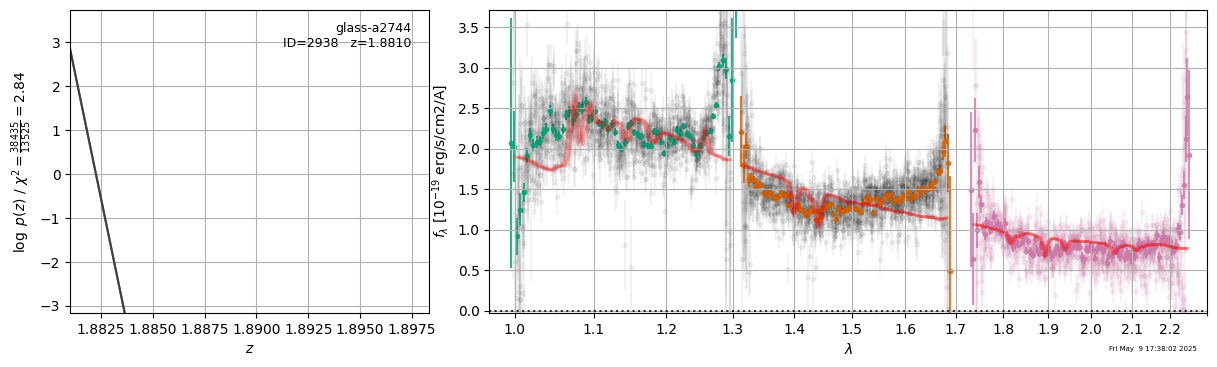

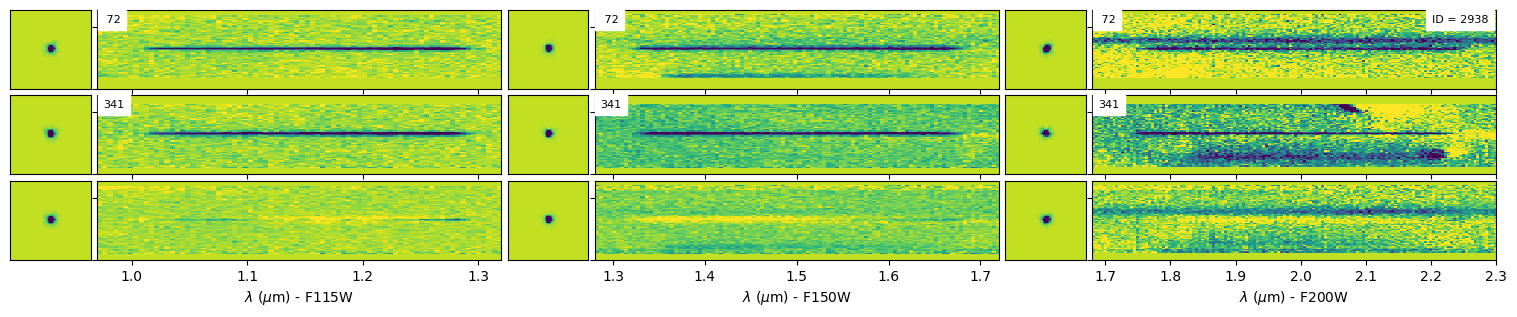

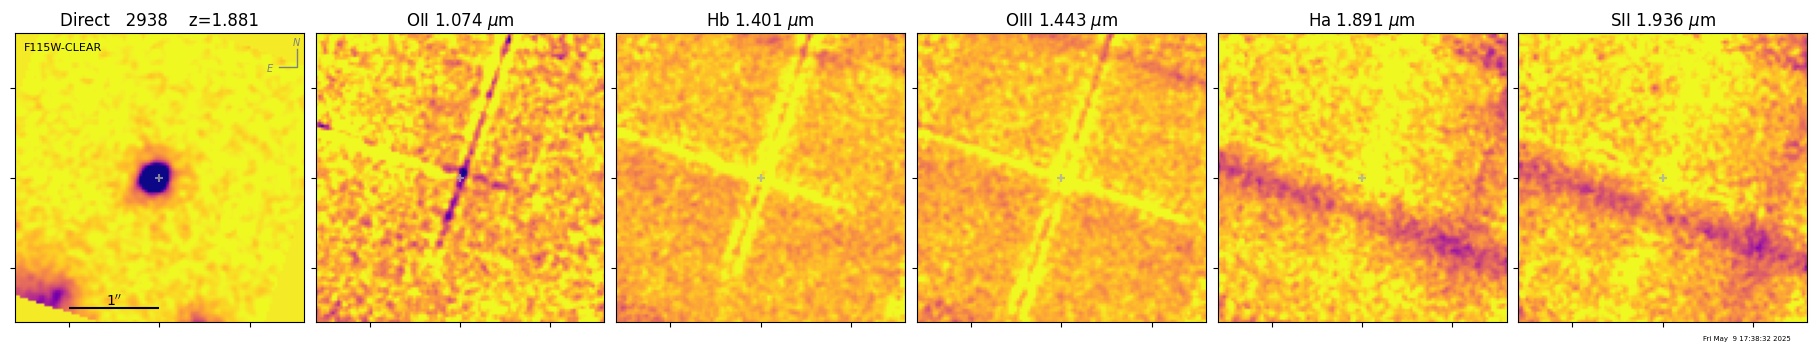

In [12]:
os.chdir(grizli_home_dir / "Extractions")
flt_files = [str(s) for s in Path.cwd().glob("*GrismFLT.fits")][:]

grp = multifit.GroupFLT(
    grism_files=flt_files,
    catalog=f"{root_name}-ir.cat.fits",
    cpu_count=-1,
    sci_extn=1,
    pad=800,
)
from grizli import fitting

pline = {
    "kernel": "square",
    "pixfrac": 1.0,
    "pixscale": 0.03,
    "size": 50,
    "wcs": None,
}
args = auto_script.generate_fit_params(
    pline=pline,
    field_root=root_name,
    min_sens=0.0,
    min_mask=0.0,
    # Set both of these to True to include photometry in fitting
    include_photometry=False,  
    use_phot_obj=False,
)

obj_id = 2663
obj_z = 2.6724

obj_id = 2938
obj_z = 1.891

beams = grp.get_beams(
    obj_id,
    size=25, 
    min_mask=0,
    min_sens=0,
    show_exception=True,
    beam_id="A",
)
mb = multifit.MultiBeam(
    beams, fcontam=0.2, min_sens=0.0, min_mask=0, group_name=root_name
)
# mb.fit_trace_shift()
mb.write_master_fits()

_ = fitting.run_all_parallel(
    obj_id,
    zr=[obj_z-0.01, obj_z + 0.01],
    dz=[0.001,0.0001],
    verbose=True,
    get_output_data=True,
    skip_complete=False,
    save_figures=True,
)